The positions of the ball were recorded manually with positionTaker.py and written to a CSV file, see positionTaker.py


![Ball](data/ballFoto.png)

The first goal was to calculate the throw distance, flight time and the equation of motion and to compare this with the measured values ​​or Kalman values ​​(in 2D)
FYI: the ball moves from right to left in the video and vice versa in the formulary. The principle remains the same.

![Wurfparabel](data/Wurfparabel.png)


In [5]:
from kalmanfilter import KalmanFilter
import cv2 as cv
import csv 
import matplotlib.pyplot as plt
import math
file = open('data/ballPosition.csv')
kf = KalmanFilter()

The current kalmanfilter uses a linar motion model and can therfore only predict in a stright line.   
![Kalman-Without-Correction](data/KalmanWithoutCorrection.png)   
After the 50th point there is no more correction and the Kalmanfilter just keeps on precicting in a stright line.  
We need to alter the motion model to a non-linear model. So that the predicted trajectory is shaped like a parabola and to like a line.

In [6]:
x_ball = []
y_ball = []
csvreader = csv.reader(file)
for row in csvreader:
    if(row != ['x;y']):
        rc = row[0]
        row = rc.split(";")
        x_ball.append(int(row[0]))
        y_ball.append(int(row[1]))


In [7]:
x_kal = []
y_kal = []
for i in range(len(x_ball)):
    if (True):
        predicted = kf.predict(x_ball[i], y_ball[i])
        x_kal.append(int(predicted[0]))
        y_kal.append(int(predicted[1]))
    else:
        predicted = kf.predictWithoutCorrect()
        x_kal.append(int(predicted[0]))
        y_kal.append(int(predicted[1]))

# both points are KF estimated points not measured points
y_0 = (x_kal[42],y_kal[42])               
thePointAfter_y_0 = (x_kal[43],y_kal[43])

# video was taken with 151.51 fps, see videos properties in detail, so the the for 2 frames is s = 2/157.51 in seconds
s = 2/157.51

# distance between two frames in px
m = math.sqrt(math.pow(y_0[0] - thePointAfter_y_0[0],2) + math.pow(y_0[1] - thePointAfter_y_0[1],2))

#launch angle
alpha = math.asin(abs(y_0[1] - thePointAfter_y_0[1])/m)

# we assumed that one meter in real world would correspond to 790 pixels. So acceleration due to gravity in px/s^2. It would be more accurate with camera calibration.
g = 9.81*790

# speed in px/s
v_0 = m / s

# equation of motion from the formulary dependent on the time
x_t = [y_0[0] - v_0*math.cos(alpha)*0.0001*i for i in range(0,4300)]
y_t = [-0.5*g*math.pow(0.0001*i,2) + v_0*0.0001*i*math.sin(alpha) + y_0[1] for i in range(0,4300)]

# constants
c_1 = (2*y_0[1]*g)/math.pow(v_0,2)
c_2 = v_0*v_0/g

flightTimeForm_y_0 = v_0/g*abs(math.sin(alpha) +  math.sqrt(math.pow(math.sin(alpha),2)+c_1))
throwDistance =c_2 * math.cos(alpha)*abs(math.sin(alpha) + math.sqrt((math.sin(alpha)*math.sin(alpha))+ c_1))
totalFlightTime = len(x_ball)/157.51

print("Flight time from beginning until the end:",totalFlightTime)
print("Flight time from y_0 until the end:",flightTimeForm_y_0)
print("The total distance, i.e. from the first impact to the landing point (measuring points):",math.sqrt(math.pow(x_ball[0] - x_ball[-1],2) +  math.pow(y_ball[0] - y_ball[-1],2)), "px")
print("Throw distance according to the formula:",throwDistance,"px")
print("The distance from the estimated point with KF to the end:",math.sqrt(math.pow(x_ball[0] - x_ball[-1],2) +  math.pow(y_ball[0] - y_ball[-1],2))-abs(y_0[0]-x_ball[0]), "px")
print("The difference is",9,"px or",900/790,"cm (in 2D)")

Flight time from beginning until the end: 0.6793219478128373
Flight time from y_0 until the end: 0.45460343411123544
The total distance, i.e. from the first impact to the landing point (measuring points): 768.4744628157789 px
Throw distance according to the formula: 465.4298148945945 px
The distance from the estimated point with KF to the end: 454.4744628157789 px
The difference is 9 px or 1.139240506329114 cm (in 2D)


The currect precition with the trajectory parabola utilizes only 2 points to predict the future position of the object and these two points are cherrypicked.   
If these two points are changed to two different points the prediction is looking really bad.   

![FailedParabola](data/FailedParabola.png)   

There is a way to interpolate a parabola through a given set of points, that would definitely be a better and more accurate way of predicting the future positon of the object.

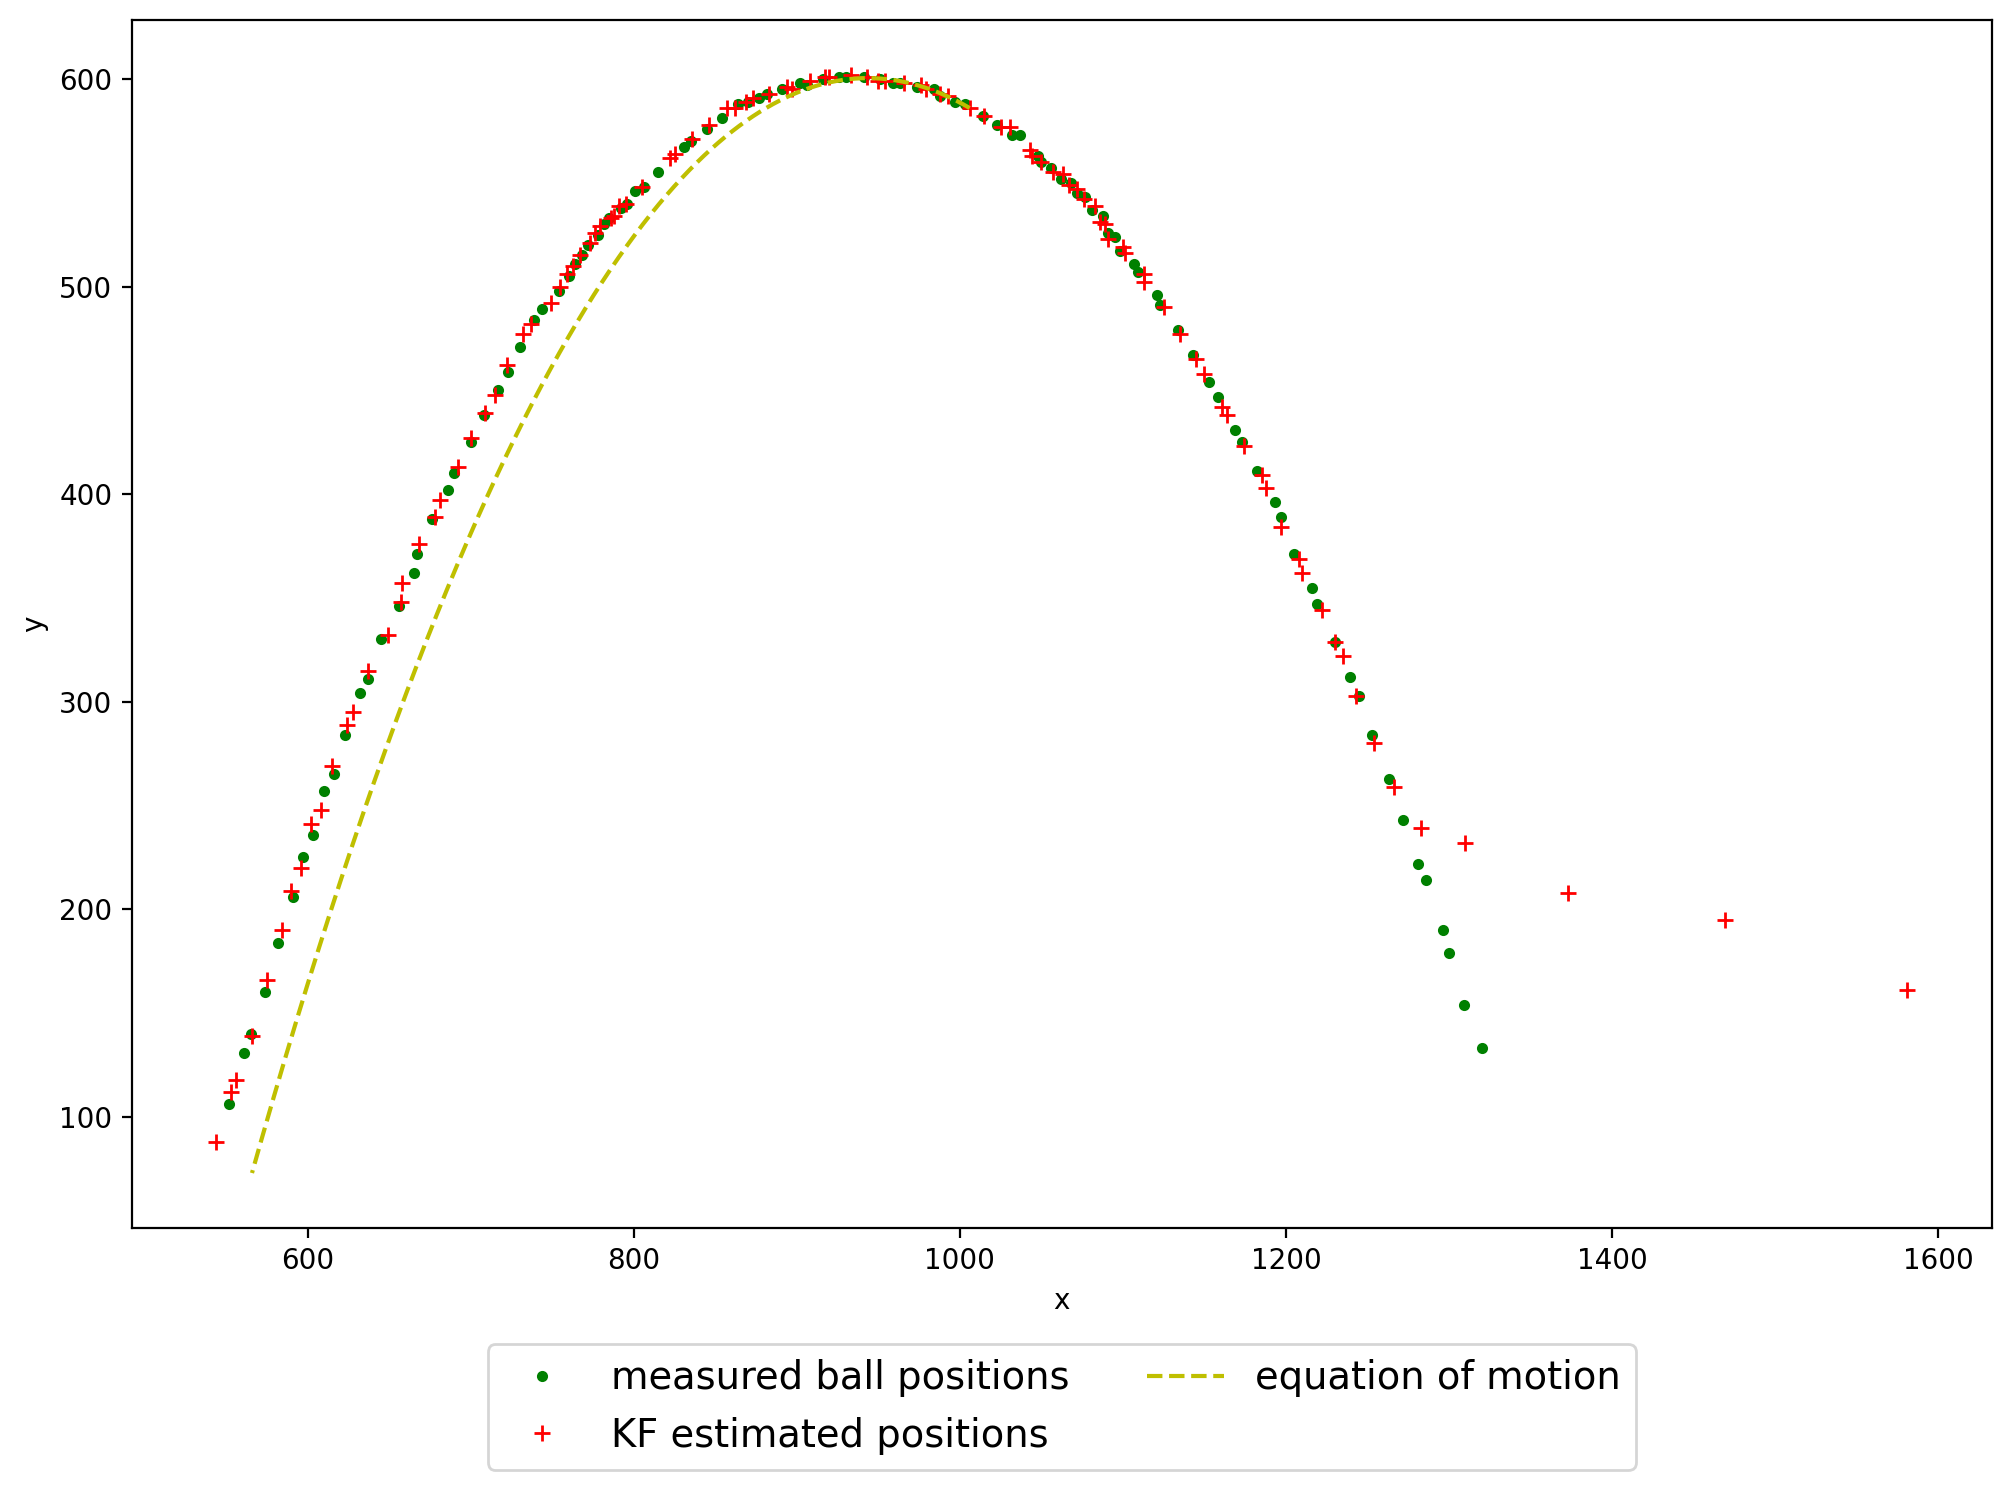

In [8]:
# at the begining estimates KF very bad. For plotting the points it is better to delete this point
del x_kal[0]
del y_kal[0]

plt.plot(x_ball,y_ball,'g.', label = "measured ball positions")
plt.plot(x_kal,y_kal,'r+', label = "KF estimated positions")
plt.plot(x_t,y_t,'y--', label = "equation of motion")
plt.xlabel('x')
plt.ylabel('y')

plt.legend(loc='upper center', prop={'size':13.89}, 
           bbox_to_anchor=(0.5, -0.08), ncol=2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.show()